In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 경고메세지 무시
import warnings
warnings.filterwarnings("ignore")

# ARIMA를 활용하여 서울 월 평균 기온 예측하기 프로젝트

In [6]:
# 서울의 일일 기온데이터 (1907.10~2024.3)를 불러와 보겠습니다.
seoul = pd.read_csv('seoul.csv', encoding = 'cp949')
seoul

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,\t1907-10-01,108.0,13.5,7.9,20.7
1,\t1907-10-02,108.0,16.2,7.9,22.0
2,\t1907-10-03,108.0,16.2,13.1,21.3
3,\t1907-10-04,108.0,16.5,11.2,22.0
4,\t1907-10-05,108.0,17.6,10.9,25.4
...,...,...,...,...,...
42099,\t2024-03-10,108.0,4.2,-1.8,10.6
42100,\t2024-03-11,108.0,6.2,2.0,10.8
42101,\t2024-03-12,108.0,6.6,4.4,10.0
42102,\t2024-03-13,108.0,6.5,1.3,12.0


In [7]:
# 이번 시간에는 평균기온에만 관심을 두겠습니다.
df = seoul[['날짜', '평균기온(℃)']].rename(columns = {'날짜' : 'Date', '평균기온(℃)' : 'Temp'})
df.head()

,Date,Temp
0,\t1907-10-01,13.5
1,\t1907-10-02,16.2
2,\t1907-10-03,16.2
3,\t1907-10-04,16.5
4,\t1907-10-05,17.6


In [8]:
df.tail()
# 원래는 결측치가 있는지 봐야겠지만, 제가 미리 봤기 때문에 마지막 행 Date 컬럼엔 빈 문자열이 들어가 있어서 isnull()로도 안보인다고 특별히 알려드리겠습니다.
# 참고로 Temp 컬럼엔 결측치가 다수 존재하긴 하지만, 기간을 끊어서 볼 예정이기 때문에 따로 전처리를 하진 않겠습니다.

,Date,Temp
42099,\t2024-03-10,4.2
42100,\t2024-03-11,6.2
42101,\t2024-03-12,6.6
42102,\t2024-03-13,6.5
42103,\t,NaN


In [9]:
df = df.drop(42103, axis = 0) # 마지막 행만 제거해줍니다.

In [10]:
# 지금 Date는 문자열 타입이기 때문에, 시계열 분석을 위해 datetime 타입으로 바꿔주도록 하겠습니다.
# dt.to_period('M')은 datetime 데이터를 월단위로 끊어서 보겠다는 뜻입니다. (우리는 일별이 아니라 월별로 볼 예정이기 때문)
# 다만 이경우 자료형이 period('M')이 되어버리기 때문에, 다시 이를 dt.to_timestamp()를 활용해 datetime으로 되돌려 주겠습니다.
df['Date'] = pd.to_datetime(df['Date'].str.strip(), format="%Y-%m-%d").dt.to_period("M").dt.to_timestamp()
df.head()

,Date,Temp
0,1907-10-01,13.5
1,1907-10-01,16.2
2,1907-10-01,16.2
3,1907-10-01,16.5
4,1907-10-01,17.6


In [11]:
df = df.groupby(['Date'])['Temp'].mean() # 이제 월단위로 groupby를 해서 월평균 기온 데이터프레임을 생성하겠습니다.
df

Date
1907-10-01    13.896774
1907-11-01     5.310000
1907-12-01    -3.890323
1908-01-01    -3.464516
1908-02-01    -4.058621
                ...    
2023-11-01     6.796667
2023-12-01     1.116129
2024-01-01    -0.487097
2024-02-01     3.820690
2024-03-01     3.884615
Name: Temp, Length: 1384, dtype: float64

In [12]:
after2010 = df[df.index.year >= 2010] # 이번 시간에는 2010년부터의 시계열 데이터만 갖고 분석을 진행해보겠습니다.
after2010

Date
2010-01-01    -4.496774
2010-02-01     1.414286
2010-03-01     4.267742
2010-04-01     9.523333
2010-05-01    17.151613
                ...    
2023-11-01     6.796667
2023-12-01     1.116129
2024-01-01    -0.487097
2024-02-01     3.820690
2024-03-01     3.884615
Name: Temp, Length: 171, dtype: float64

### 시각화

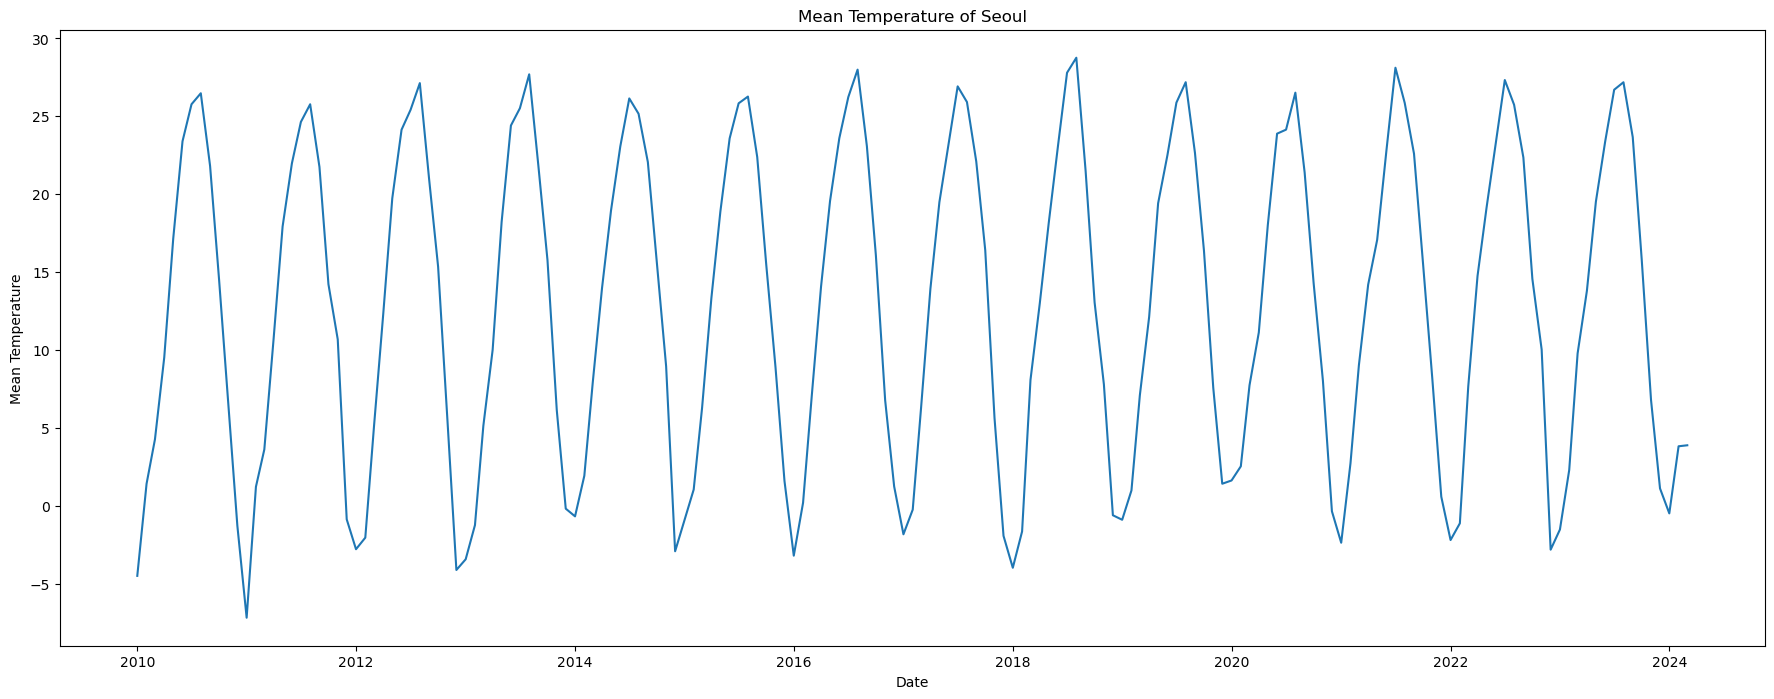

In [13]:
plt.figure(figsize=(22,8))
plt.plot(after2010)
plt.title('Mean Temperature of Seoul')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.show()

# 명확한 계절성이 보입니다. 비정상 시계열이라고 의심을 해볼 수 있을 것 같습니다.

### 요소 분해

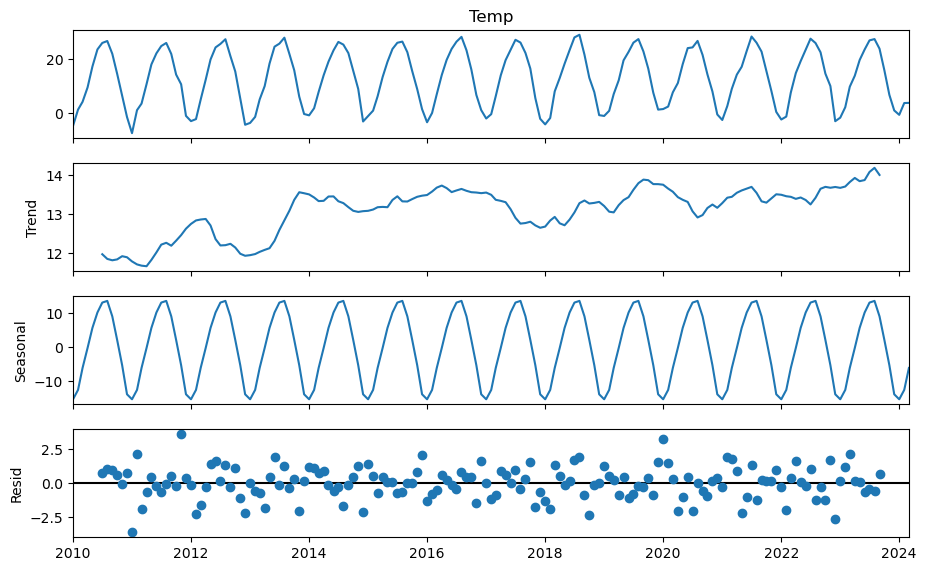

In [14]:
import statsmodels.api as sm

# additive 방식을 활용한 분해
decomposition = sm.tsa.seasonal_decompose(after2010, model='additive', period=12)
# 방금의 시각화를 통해 이 시계열 데이터가 1년단위의 계절성을 갖는다는 것을 파악했습니다. 지금 데이터는 월단위이므로 period = 12로 보는 편이 바람직합니다. 만약 일단위였다면 365로 해주면 되겠죠?
fig = decomposition.plot()
fig.set_size_inches(10, 6)
plt.show()

### 정상성 검정

In [15]:
# ADF 검정
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, **kw):
    adf, p_value, nlags, number_of_observations, critical_values, _ = adfuller(series, **kw)

    print(f'ADF: {adf:.5f}')
    print(f'p-value: {p_value:.2f}')
    print(f'Lags: {nlags}')
    print(f'Number of Observations: {number_of_observations}')

    print(f'검증결과: {"비정상(non-stationary)" if p_value > 0.05 else "정상(stationary)"} 시계열 데이터입니다.')

# KPSS 검정
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    stats, p_value, nlags, critical_values = kpss(series, **kw)

    print(f'KPSS Stat: {stats:.5f}')
    print(f'p-value: {p_value:.2f}')
    print(f'Lags: {nlags}')

    print(f'검증결과: {"비정상(non-stationary)" if p_value <= 0.05 else "정상(stationary)"} 시계열 데이터입니다.')

In [16]:
adfuller_test(after2010)

ADF: -2.36607
p-value: 0.15
Lags: 12
Number of Observations: 158
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


In [17]:
kpss_test(after2010)

KPSS Stat: 0.02676
p-value: 0.10
Lags: 6
검증결과: 정상(stationary) 시계열 데이터입니다.


두 검정 결과가 다릅니다. ACF & PACF 그래프까지 참고해 보겠습니다.

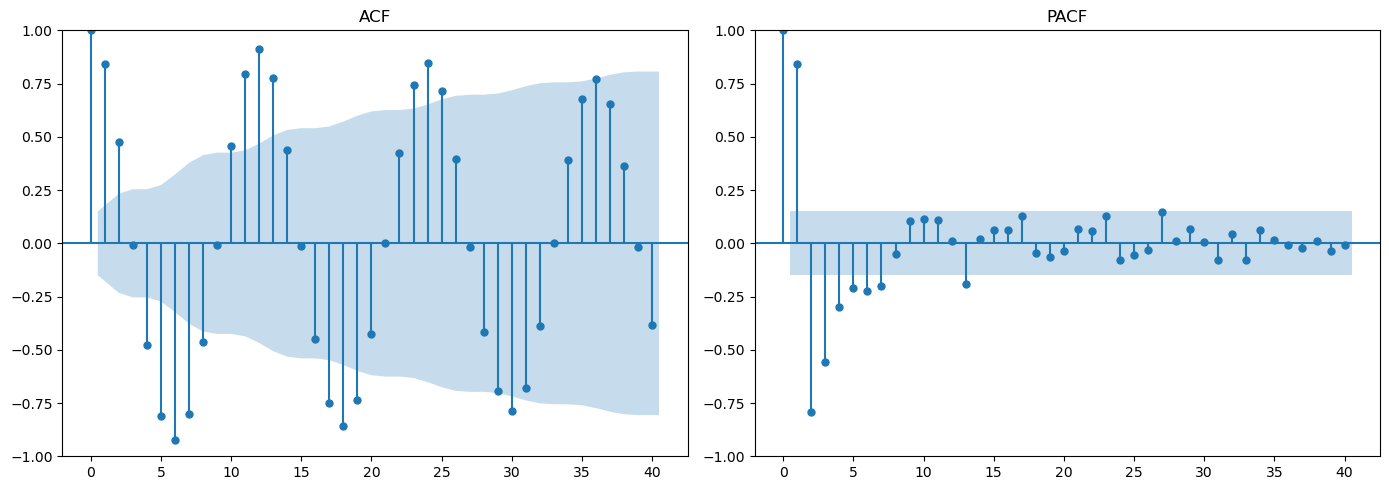

In [18]:
# ACF & PACF 그래프 그리기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(after2010, ax=axes[0], lags=40)
axes[0].set_title("ACF")

# PACF
plot_pacf(after2010, ax=axes[1], lags=40)
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

ACF 그래프가 주기성을 갖고 계속 파랑색 영역 (신뢰구간)을 벗어나고 있습니다.   
정상 시계열이라고 보기엔 어려울 것 같습니다.

### 차분

In [19]:
# 가장 일반적인 방식인 차분 먼저 진행해 보겠습니다.
after2010_diff = after2010.diff().dropna() # 차분하면 생기는 결측치까지 제거해주세요.

In [20]:
adfuller_test(after2010_diff) # 차분을 수행한 것만으로 아까와 달리 ADF 정상성 검정을 통과했습니다.

ADF: -10.87816
p-value: 0.00
Lags: 11
Number of Observations: 158
검증결과: 정상(stationary) 시계열 데이터입니다.


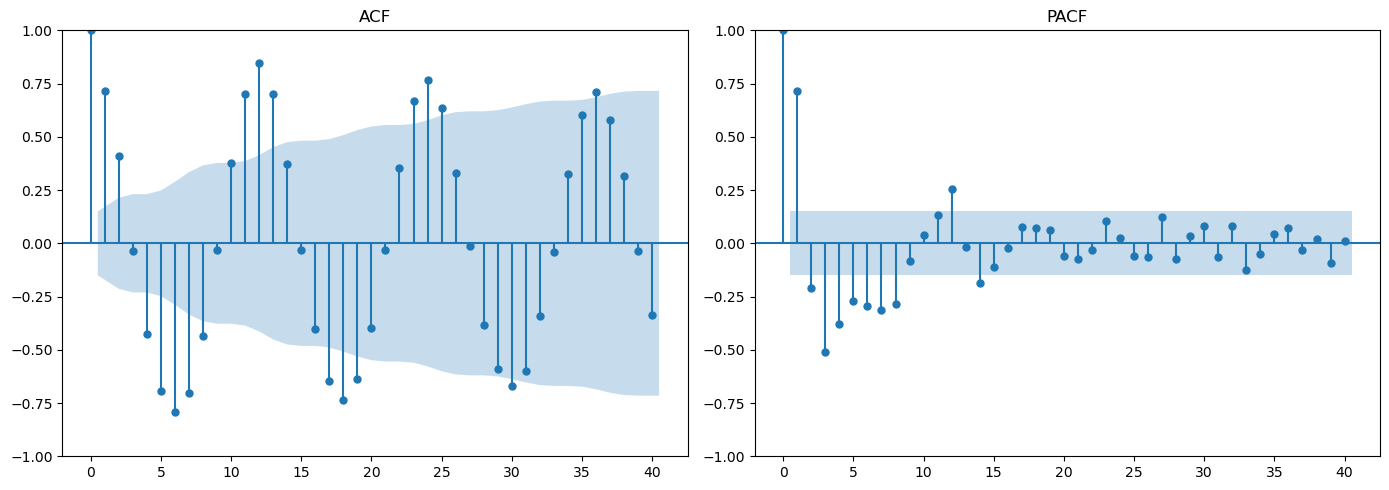

In [21]:
# ACF & PACF 그래프 그리기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(after2010_diff, ax=axes[0], lags=40)
axes[0].set_title("ACF")

# PACF
plot_pacf(after2010_diff, ax=axes[1], lags=40)
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

다만 ACF 그래프에서는 여전히 정상성이 확보되었다고 보기 애매한 상황입니다.   
사실 지금은 계절성이 강한 편이다 보니 일반 차분보다는 계절 차분이 더 나은 선택일 수도 있을 것 같습니다.

#### 참고 (ACF, PACF 그래프 보는 법)

여기서 ACF, PACF 그래프를 활용해 추후 ARIMA 모델에 들어가야 할 인자도 결정할 수 있습니다.    
세션 시간에 전달이 정확히 되지 않은 부분이 있어 추가로 설명하겠습니다.   
ACF 그래프가 뚝 떨어지는 시점을 MA(q)의 차수, PACF 그래프가 뚝 떨어지는 시점을 AR(p)의 차수로 본다고 말했는데요,   
이때 그래프의 x축은 시차(lag), y축은 자기상관성을 의미한다고 보시면 편합니다.   
그래서 맨처음 값이 1인 것은 시차가 0일때, 즉 자기자신과의 상관계수는 항상 1이기 때문에 그렇게 되는 것입니다.   
지금 ACF 그래프로는 정상성 확보가 덜 된 상태라고 보이지만, 확보가 되었다고 가정하고 MA(p)의 차수를 정한다면 p = 3이라고 생각해볼 수 있겠습니다.   
lag 0, 1, 2일때까지는 파란색 영역(신뢰구간) 밖에 있지만 3부터 신뢰구간 안으로 들어왔고, 거의 0에 수렴하기 때문입니다.

### 계절차분

In [22]:
after2010_diff12 = after2010.diff(12).dropna() # 현재 주기가 12이므로 계절차분을 할 땐 diff(12)를 통해 해주면 되겠습니다.

In [23]:
adfuller_test(after2010_diff12) # 마찬가지로 ADF 정상성 검정을 통과했습니다.

ADF: -6.44728
p-value: 0.00
Lags: 11
Number of Observations: 147
검증결과: 정상(stationary) 시계열 데이터입니다.


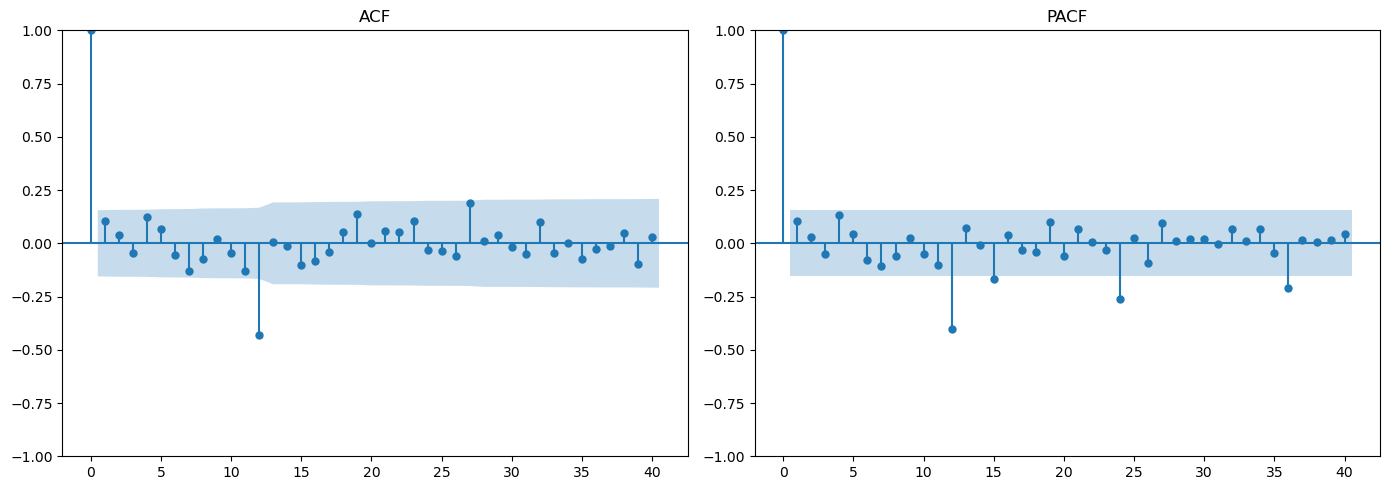

In [24]:
# ACF & PACF 그래프 그리기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(after2010_diff12, ax=axes[0], lags=40)
axes[0].set_title("ACF")

# PACF
plot_pacf(after2010_diff12, ax=axes[1], lags=40)
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

신뢰구간 영역 밖의 케이스가 있긴 하지만, ACF 그래프가 빠르게 0으로 수렴하고 있는 걸로 보아 정상성을 잘 확보했다고 볼 수 있겠습니다.

### ARIMA 모델링

이제 앞서 확인한 ACF, PACF 그래프를 통해 ARIMA 모델의 차수를 결정해 주겠습니다.   
지금은 계절성으로 인해 SARIMA가 더 좋아보이긴 하지만, 일단 계절성은 배제하고 ARIMA 모델만 먼저 사용해 보겠습니다.   
차분을 통해 어느정도 약정상성을 확보했다고 치고, 1차 차분을 한 ACF, PACF 그래프를 바탕으로 차수를 결정해 봅시다.

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
# 차분을 한 번 한 상태에서 ACF, PACF 그래프를 보면 각각 lag 3, 2에서 급감하는 것을 볼 수 있습니다. (물론 신뢰구간 안으로 들어오지 않아 다소 애매한 상황이긴 합니다.)
# 만약 위와 같이 해석하고 ARIMA 차수를 결정했다면, 이때 order 인자에는 어떤 값들이 들어와야 할까요? 또 데이터프레임은 어떤 것을 넣어줘야 할까요?
model = ARIMA(after2010, order=(2,1,3))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                  171
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -347.178
Date:                Fri, 06 Jun 2025   AIC                            706.357
Time:                        16:49:07   BIC                            725.171
Sample:                    01-01-2010   HQIC                           713.991
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7315      0.001   3250.385      0.000       1.730       1.733
ar.L2         -0.9999      0.000  -4926.988      0.000      -1.000      -0.999
ma.L1         -2.6868      0.052    -51.724      0.0

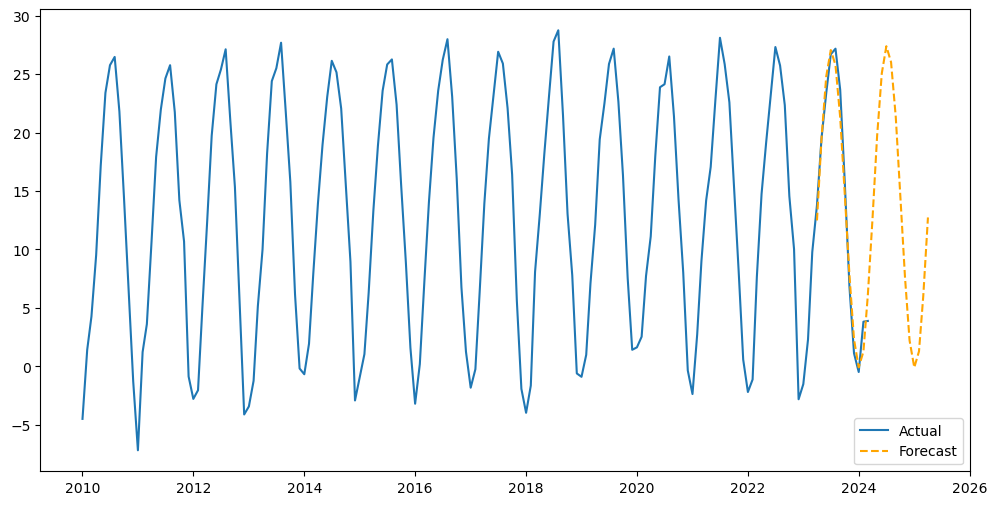

In [26]:
forecast = model_fit.predict(start=len(after2010)-12, end=len(after2010)+12, typ='levels') # predict 함수를 통해 예측값을 확인할 수 있습니다.
# start와 end의 범위를 다음과 같이 지정해줌으로써 2024년 3월을 기점으로 +- 1년에 대한 모델의 예측값을 시각화 해보겠습니다.
# 주의 : 차분이 들어간 모델의 경우 typ을 default 파라미터인 'linear'로 설정해 줄 경우 차분한 값에 대한 결과가 나옵니다. 원본 스케일에 맞게 해석하기 위해선 typ = 'levels'로 지정해주면 됩니다.


plt.figure(figsize=(12,6))
plt.plot(after2010, label='Actual')
plt.plot(forecast, label='Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

In [27]:
!pip install pmdarima

지금까지 우리는 ACF, PACF 그래프를 통해 수작업으로 ARIMA 모델의 하이퍼파라미터를 결정해 보았습니다.   
휴리스틱으로 파라미터를 하나 정해 베이스 모델을 만든 뒤, 차수를 조금씩 바꿔보며 AIC, BIC가 가장 낮은 때가 언제인지 찾아보는 과정을 통해 더 정교한 모델링을 할 수 있습니다.   
다만 수작업이 불편하신 분들을 위해 grid_search로 최적의 파라미터를 대신 찾아주는 auto_arima에 대해서도 소개를 해 드리곘습니다.

In [28]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(after2010, seasonal=True, m = 12, trace=True)
# 데이터에 계절성이 있다는 것을 확인했기 때문에 seasonal = True, 1년 단위이므로 m = 12로 인자를 지정합니다.
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=586.403, Time=1.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=652.543, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=617.315, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=651.278, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=590.093, Time=2.20 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=603.089, Time=2.59 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=592.163, Time=3.38 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.68 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  171
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -285.201
Date:                              Fri, 06 Jun 2025   AIC                            586.403
Time:                                      16:50:18   BIC                            610.954
Sample:                                  01-01-2010   HQIC                           596.373
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2072      0.059      3.520      0.000       0.092       0.323
ar.L1          0.2005      0.066      3.023      0.003       0.071       0.331
ar.L2         -0.9601      0.059    -16.306      0.000      -1.075      -0.845
ma.L1         -0.1449      0.070     -2.057      0.040      -0.283      -0.007
ma.L2          0.9649      0.065     14.764      0.000       0.837       1.093
ar.S.L12       0.0500      0.110      0.454      0.650      -0.166       0.266
ma.S.L12      -0.8854      0.133     -6.657      0.000      -1.146      -0.625
sigma2         1.8610      0.262      7.104      0.000       1.348       2.374
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.48   Prob(JB):                         0.71
Heteroskedasticity (H):               1.01   Skew:                            -0.10
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC 기준으로 최적의 파라미터를 찾아주는 것을 볼 수 있습니다.

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
# 방금 확인한 최적의 파라미터를 넣어 봅시다.
sarima_model = SARIMAX(after2010, order=(2,0,2), seasonal_order=(1,1,1,12))
# 지금은 seasonal_order = (P,D,Q,s)라는 인자도 추가되었는데, 여기서 D는 계절차분의 횟수를, s는 주기를 의미합니다. P와 Q도 각각 PACF, ACF의 주기를 따라가게 됩니다.
sarima_model_fit = sarima_model.fit()

print(sarima_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Temp   No. Observations:                  171
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -288.931
Date:                              Fri, 06 Jun 2025   AIC                            591.863
Time:                                      16:51:18   BIC                            613.345
Sample:                                  01-01-2010   HQIC                           600.587
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0657      0.145      0.454      0.650      -0.218       0.349
ar.L2          0.93

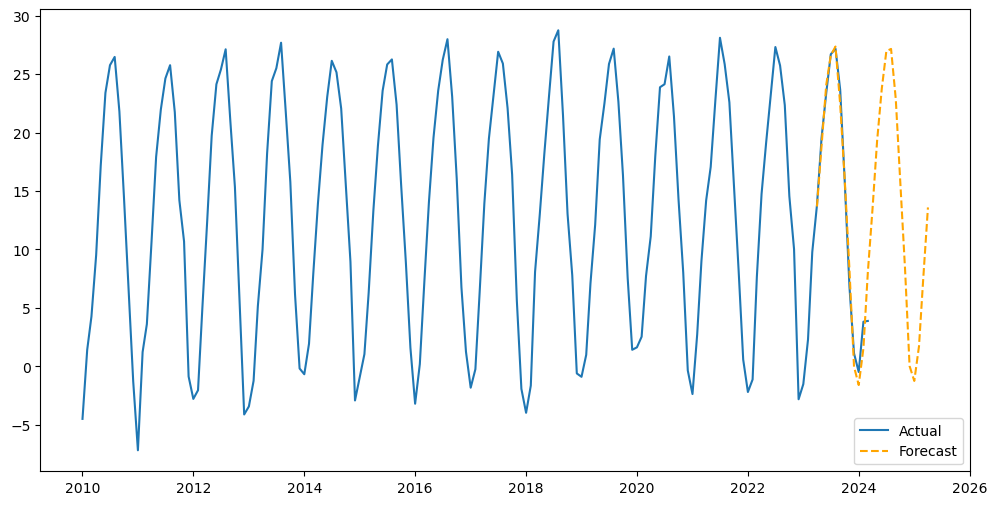

In [30]:
sarima_forecast = sarima_model_fit.predict(start=len(after2010)-12, end=len(after2010)+12, typ='levels')

plt.figure(figsize=(12,6))
plt.plot(after2010, label='Actual')
plt.plot(sarima_forecast, label='Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

그래프상으로는 형태가 비슷해보이지만, ARIMA(2,1,3) 모델보다 SARIMA(2,0,2)x(1,1,1,12) 모델의 AIC 스코어가 더 낮은 것을 볼 수 있습니다.   
따라서 지금같은 경우는 계절성을 고려하여 계절차분을 수행하는 SARIMA 모델이 더 낫다고 볼 수 있겠습니다.

In [31]:
# 번외 : 나쁜 모델
from statsmodels.tsa.arima.model import ARIMA

# fit model
bad_model = ARIMA(after2010, order=(1,0,0)) # ARIMA(1,0,0)은 그냥 AR(1) 모형이겠죠? 정상성 확보도 안한채로 그냥 진행해 봅시다.
bad_model_fit = bad_model.fit()

print(bad_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                  171
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -531.205
Date:                Fri, 06 Jun 2025   AIC                           1068.410
Time:                        16:51:44   BIC                           1077.835
Sample:                    01-01-2010   HQIC                          1072.235
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0333      2.872      4.189      0.000       6.404      17.663
ar.L1          0.8546      0.052     16.377      0.000       0.752       0.957
sigma2        29.0027      5.053      5.740      0.0

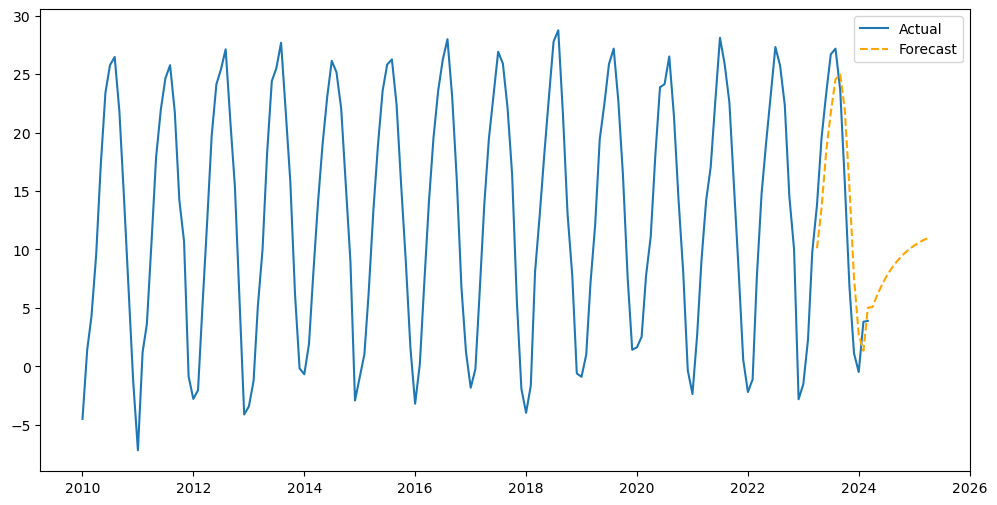

In [32]:
bad_forecast = bad_model_fit.predict(start=len(after2010)-12, end=len(after2010)+12, typ='levels')

plt.figure(figsize=(12,6))
plt.plot(after2010, label='Actual')
plt.plot(bad_forecast, label='Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

AIC도 높아졌고, 그래프도 이상하게 나오네요...   
적절한 차수 선택 (그리고 정상성 확보)의 중요성을 다시 한번 깨닫고 갑시다.   
다들 고생하셨습니다!